In [26]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import regex as re

In [27]:
import datetime

def getDate(s,datetype = "UTC"):
    start_index1 = s.find(datetype + "Date")
    end_index1 = start_index1 + 9

    start_index2 = s.find(datetype + "Time")
    end_index2 = start_index2 + 9

    

    date_string = '{} {}'.format(s[end_index1:end_index1 + 10],s[end_index2:end_index2 + 8])
    date_format = '%Y.%m.%d %H:%M:%S'

    #print(date_string)

    return datetime.datetime.strptime(date_string,date_format)

def getNumMoves(pgn_only):
    move_nums = re.findall(r' [0-9]+\.+ ',pgn_only)
    if len(move_nums)==0:
        return 1
    largestMoveStr = move_nums[-1][1:move_nums[-1].index('.')]
    return int(largestMoveStr)
    

def getPGNInfo(pgn):
    pgn_only = pgn.split('\n')[-2]
    return {
        'start_time': getDate(pgn,'UTC'),
        'end_time':getDate(pgn,'End'),
        'num_moves':getNumMoves(pgn_only)
    }

    


def getPlayersAndResult(whiteJSON,blackJSON,player="rohitg1234"):
    white_username = whiteJSON['username']
    white_rating = whiteJSON['rating']

    black_username = blackJSON['username']
    black_rating = blackJSON['rating']

    player_colour = 'white' if white_username == player else 'black'
    opponent_colour = 'white' if white_username != player else 'black'
    player_rating = white_rating if player_colour=='white' else black_rating
    opponent_rating = white_rating if player_colour!='white' else black_rating
    rating_difference = player_rating - opponent_rating


    white_result = whiteJSON['result']
    black_result = blackJSON['result']
    if white_result == 'win':
        winner = 'white'
    elif black_result == 'win':
        winner = 'black'
    else:
        winner = 'draw'

    player_result = 'draw' if winner == 'draw' else ('win' if player_colour == winner else 'loss')
    player_result_value = 0.5 if winner == 'draw' else (1 if player_colour == winner else 0)
    result_method = white_result if winner=='black' else black_result

    return {
        'white_username':white_username,
        'white_rating':white_rating,
        'white_result':white_result,
        'black_rating':black_rating,
        'black_username':black_username,
        'black_result':black_result,
        'player_colour':player_colour,
        'player_rating':player_rating,
        'opponent_colour':opponent_colour,
        'opponent_rating':opponent_rating,
        'rating_difference':rating_difference,
        'player_result':player_result,
        'player_result_value':player_result_value,
        'result_method':result_method
    }

In [28]:
url_template = r"https://api.chess.com/pub/player/rohitg1234/games/{}/{}"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
    

In [10]:
username = 'rohitg1234'
run_code = True

if run_code:
    start_year = 2018
    start_month = 9

    end_year = 2024
    end_month = 2

    #url = "https://api.chess.com/pub/player/{}/games/{}/{}"


    get_year = start_year
    get_month = start_month

    data_json_list = []

    while(get_year*100+get_month <= end_year*100 + end_month):
        url = "https://api.chess.com/pub/player/{}/games/{}/{}".format(username,str(get_year),(2-len(str(get_month)))*'0' + str(get_month))
        #print(url)
        data = requests.get(url,headers=headers)
        data_json_list += data.json()['games']

        get_month += 1
        if get_month == 13:
            get_year += 1
            get_month = 1



    with open("{} chess history.json".format(username), "w") as f:
        f.write(json.dumps(data_json_list))
        f.close()

In [29]:
# if not run_code:
#     with open("{} chess history.json".format(username)) as f:
#         data_json_list = json.load(f)
#         f.close()


In [30]:
total_games = len(data_json_list)
games_completed = 0
cleaned_json_list = []
for datapoint in data_json_list:
    cleaned_datapoint = {}
    cleaned_datapoint["URL"] = datapoint["url"]
    cleaned_datapoint["game_id"] = datapoint["url"].split("/")[-1]
    cleaned_datapoint["is_rated"] = datapoint["rated"]
    cleaned_datapoint["time_control"] = datapoint["time_control"]
    cleaned_datapoint["time_class"] = datapoint["time_class"]
    pgn_str = datapoint["pgn"]
    cleaned_datapoint = cleaned_datapoint | getPGNInfo(pgn_str)
    cleaned_datapoint["duration"] = cleaned_datapoint["end_time"] - cleaned_datapoint["start_time"]
    cleaned_datapoint = cleaned_datapoint | getPlayersAndResult(datapoint['white'],datapoint['black'])
    cleaned_json_list.append(cleaned_datapoint)

    games_completed +=1
    print('Games completed: {}/{} ({:.1f}%)'.format(games_completed,total_games,100*games_completed/total_games),end='\r')

In [31]:
df = pd.DataFrame(cleaned_json_list)

In [32]:
df.head()

,URL,game_id,is_rated,time_control,time_class,start_time,end_time,num_moves,duration,white_username,...,black_username,black_result,player_colour,player_rating,opponent_colour,opponent_rating,rating_difference,player_result,player_result_value,result_method
0,https://www.chess.com/game/live/3059512721,3059512721,True,600,blitz,2018-09-07 17:33:14,2018-09-07 17:35:17,3,0 days 00:02:03,rohitg1234,...,Abbido,abandoned,white,1107,black,693,414,win,1.0,abandoned
1,https://www.chess.com/game/live/3059517172,3059517172,True,600,blitz,2018-09-07 17:35:17,2018-09-07 17:51:09,43,0 days 00:15:52,WVMLL,...,rohitg1234,timeout,black,966,white,1186,-220,loss,0.0,timeout
2,https://www.chess.com/game/live/3059548861,3059548861,True,600,blitz,2018-09-07 17:51:10,2018-09-07 18:08:29,41,0 days 00:17:19,nathgomez,...,rohitg1234,timeout,black,857,white,1093,-236,loss,0.0,timeout
3,https://www.chess.com/game/live/3059583990,3059583990,True,900+10,rapid,2018-09-07 18:08:51,2018-09-07 18:20:24,22,0 days 00:11:33,rohitg1234,...,ArnoldVardanyan,abandoned,white,1171,black,1018,153,win,1.0,abandoned
4,https://www.chess.com/game/live/3059607049,3059607049,True,900+10,rapid,2018-09-07 18:20:51,2018-09-07 18:39:08,37,0 days 00:18:17,jesus_88,...,rohitg1234,resigned,black,1025,white,1122,-97,loss,0.0,resigned


In [33]:
df_blitz = df[(df["time_class"] == 'blitz')&(df['is_rated'] == True)]
df_bullet = df[df["time_class"] == 'bullet']
df_rapid = df[df["time_class"] == 'rapid']

In [34]:
df_blitz.groupby(['player_result','result_method']).agg({'white_result':'count','num_moves':'mean','rating_difference':'mean'})

white_result  num_moves  rating_difference
player_result result_method                                                 
draw          agreed                        25  44.360000          13.240000
              insufficient                  43  61.418605          -5.558140
              repetition                   135  42.459259          12.251852
              stalemate                     36  62.916667          15.194444
              timevsinsufficient            60  70.716667           1.883333
loss          abandoned                      2  20.500000         -55.500000
              checkmated                   316  34.544304         -17.430380
              resigned                    1134  29.440917         -15.071429
              timeout                      605  46.224793         -14.122314
win           abandoned                     61  21.098361          50.819672
              checkmated                   729  36.251029          62.950617
              resigned                    1091  28.860678          39.737855
              timeout                      463  44.602592          48.006479

In [35]:
df_blitz.groupby(['player_colour','player_result']).agg({'white_result':'count','num_moves':'mean','rating_difference':'mean'})

white_result  num_moves  rating_difference
player_colour player_result                                            
black         draw                    160  53.212500           6.718750
              loss                   1059  35.423041         -15.586402
              win                    1136  34.849472          46.610915
white         draw                    139  53.784173           9.575540
              loss                    998  34.865731         -14.777555
              win                    1208  33.330298          51.011589

In [36]:
df_blitz.groupby(['result_method']).agg({'white_result':'count','num_moves':'mean','player_result_value':'mean','rating_difference':'mean'})

,white_result,num_moves,player_result_value,rating_difference
result_method,,,,
abandoned,63,21.079365,0.968254,47.444444
agreed,25,44.360000,0.500000,13.240000
checkmated,1045,35.734928,0.697608,38.644019
insufficient,43,61.418605,0.500000,-5.558140
repetition,135,42.459259,0.500000,12.251852
resigned,2225,29.156404,0.490337,11.803596
stalemate,36,62.916667,0.500000,15.194444
timeout,1068,45.521536,0.433521,12.811798
timevsinsufficient,60,70.716667,0.500000,1.883333


<Axes: xlabel='start_time'>

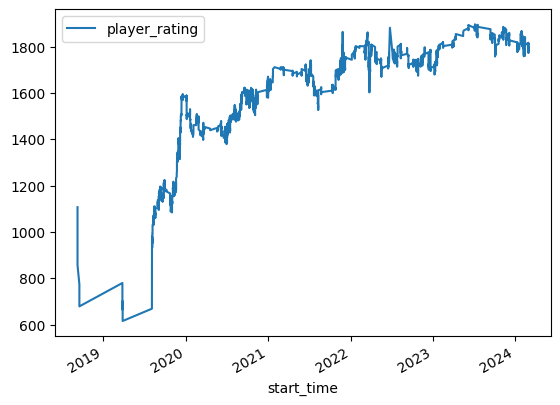

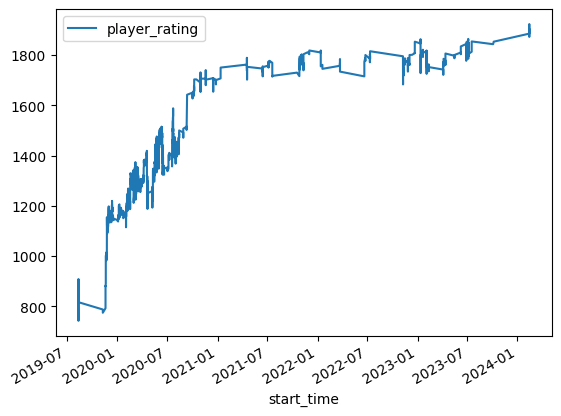

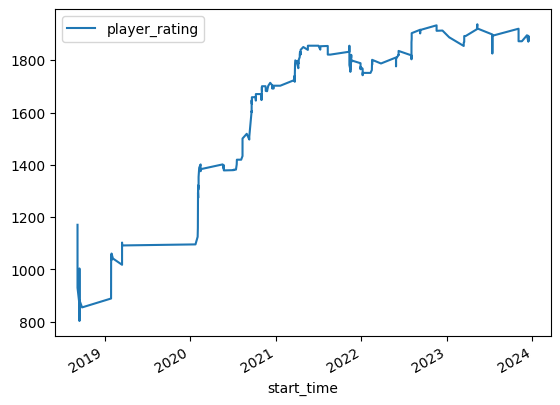

In [37]:
df_blitz.plot('start_time','player_rating')
df_bullet.plot('start_time','player_rating')
df_rapid.plot('start_time','player_rating')

In [38]:
df.sort_values(by=['start_time'],ascending=False).head()

,URL,game_id,is_rated,time_control,time_class,start_time,end_time,num_moves,duration,white_username,...,black_username,black_result,player_colour,player_rating,opponent_colour,opponent_rating,rating_difference,player_result,player_result_value,result_method
9461,https://www.chess.com/game/live/102924041075,102924041075,True,180,blitz,2024-02-29 05:39:05,2024-02-29 05:40:51,22,0 days 00:01:46,Kith4Smith,...,rohitg1234,win,black,1798,white,1789,9,win,1.0,resigned
9460,https://www.chess.com/game/live/102923973099,102923973099,True,180,blitz,2024-02-29 05:32:41,2024-02-29 05:39:05,77,0 days 00:06:24,rohitg1234,...,arya-vazifeh,insufficient,white,1790,black,1791,-1,draw,0.5,insufficient
9459,https://www.chess.com/game/live/102923422749,102923422749,True,180,blitz,2024-02-29 05:27:34,2024-02-29 05:32:46,34,0 days 00:05:12,sophdavis,...,rohitg1234,win,black,1790,white,1765,25,win,1.0,checkmated
9457,https://www.chess.com/game/live/102922861815,102922861815,True,180,blitz,2024-02-29 05:21:15,2024-02-29 05:21:25,6,0 days 00:00:10,rohitg1234,...,JorgeArenas2,win,white,1772,black,1806,-34,loss,0.0,resigned
9458,https://www.chess.com/game/live/102922864331,102922864331,True,180,blitz,2024-02-29 05:21:08,2024-02-29 05:27:32,64,0 days 00:06:24,rohitg1234,...,---Faniel,timeout,white,1782,black,1857,-75,win,1.0,timeout


In [39]:
df[df['time_class'] == 'bullet'].sort_values(by=['num_moves'],ascending=False)

,URL,game_id,is_rated,time_control,time_class,start_time,end_time,num_moves,duration,white_username,...,black_username,black_result,player_colour,player_rating,opponent_colour,opponent_rating,rating_difference,player_result,player_result_value,result_method
3935,https://www.chess.com/game/live/5006667039,5006667039,True,60,bullet,2020-06-15 19:33:54,2020-06-15 19:36:31,75,0 days 00:02:37,rohitg1234,...,lulajvi,timeout,white,1388,black,1341,47,win,1.0,timeout
3232,https://www.chess.com/game/live/4894558416,4894558416,True,60,bullet,2020-05-23 03:57:39,2020-05-23 04:00:12,73,0 days 00:02:33,mcs2001,...,rohitg1234,timevsinsufficient,black,1421,white,1565,-144,draw,0.5,timevsinsufficient
5767,https://www.chess.com/game/live/5977819676,5977819676,True,60,bullet,2020-12-16 03:36:18,2020-12-16 03:38:48,73,0 days 00:02:30,rohitg1234,...,SHRINK777,checkmated,white,1663,black,1603,60,win,1.0,checkmated
7884,https://www.chess.com/game/live/61680060231,61680060231,True,60+1,bullet,2022-11-08 20:58:05,2022-11-08 21:02:23,72,0 days 00:04:18,rohitg1234,...,khanzasubandi,win,white,1780,black,1860,-80,loss,0.0,resigned
2824,https://www.chess.com/game/live/4745601031,4745601031,True,60,bullet,2020-04-20 02:24:51,2020-04-20 02:27:17,72,0 days 00:02:26,rohitg1234,...,ayzikr,timevsinsufficient,white,1270,black,1292,-22,draw,0.5,timevsinsufficient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,https://www.chess.com/game/live/4574281494,4574281494,True,60,bullet,2020-03-08 18:52:41,2020-03-08 18:53:16,1,0 days 00:00:35,rohitg1234,...,chesshydra,win,white,1245,black,1321,-76,loss,0.0,abandoned
5551,https://www.chess.com/game/live/5694086130,5694086130,False,60,bullet,2020-11-06 02:46:55,2020-11-06 02:47:31,1,0 days 00:00:36,Anchisbad,...,rohitg1234,win,black,1706,white,1082,624,win,1.0,abandoned
3097,https://www.chess.com/game/live/4876348854,4876348854,True,60,bullet,2020-05-19 04:29:13,2020-05-19 04:29:46,1,0 days 00:00:33,RichPell,...,rohitg1234,win,black,1419,white,1322,97,win,1.0,abandoned
2873,https://www.chess.com/game/live/4821509363,4821509363,True,60,bullet,2020-05-07 04:00:09,2020-05-07 04:00:43,1,0 days 00:00:34,karen_mcdougal,...,rohitg1234,win,black,1272,white,1165,107,win,1.0,abandoned


In [40]:
def getRestrictedDF(df,num_games = None, date_range = None ,is_rated = True, time_class = 'blitz'):
    if num_games is None and date_range is None:
        print('Invalid range provided')
        df_restricted = df[(df['is_rated'] == is_rated)&(df['time_class'] == time_class)] 
    
    elif num_games is None:
        if type(date_range) is tuple:
            start_date = date_range[0]
            end_date = date_range[1]
        else:
            start_date = date_range
            end_date = datetime.datetime.today()
        df_restricted = df[(start_date <= df['start_date'])&(end_date >= df['start_date'])&(df['is_rated'] == is_rated)&(df['time_class'] == time_class)]
    
    elif date_range is None:
        if type(num_games) is tuple:
            start_range = num_games[0]
            end_range = num_games[1]
            df_restricted = df[(df['is_rated'] == is_rated)&(df['time_class'] == time_class)].iloc[start_range:end_range]
        else:
            start_range = -1*num_games
            #print('hi')
            df_restricted = df[(df['is_rated'] == is_rated)&(df['time_class'] == time_class)].iloc[start_range:]
        
    
    return df_restricted



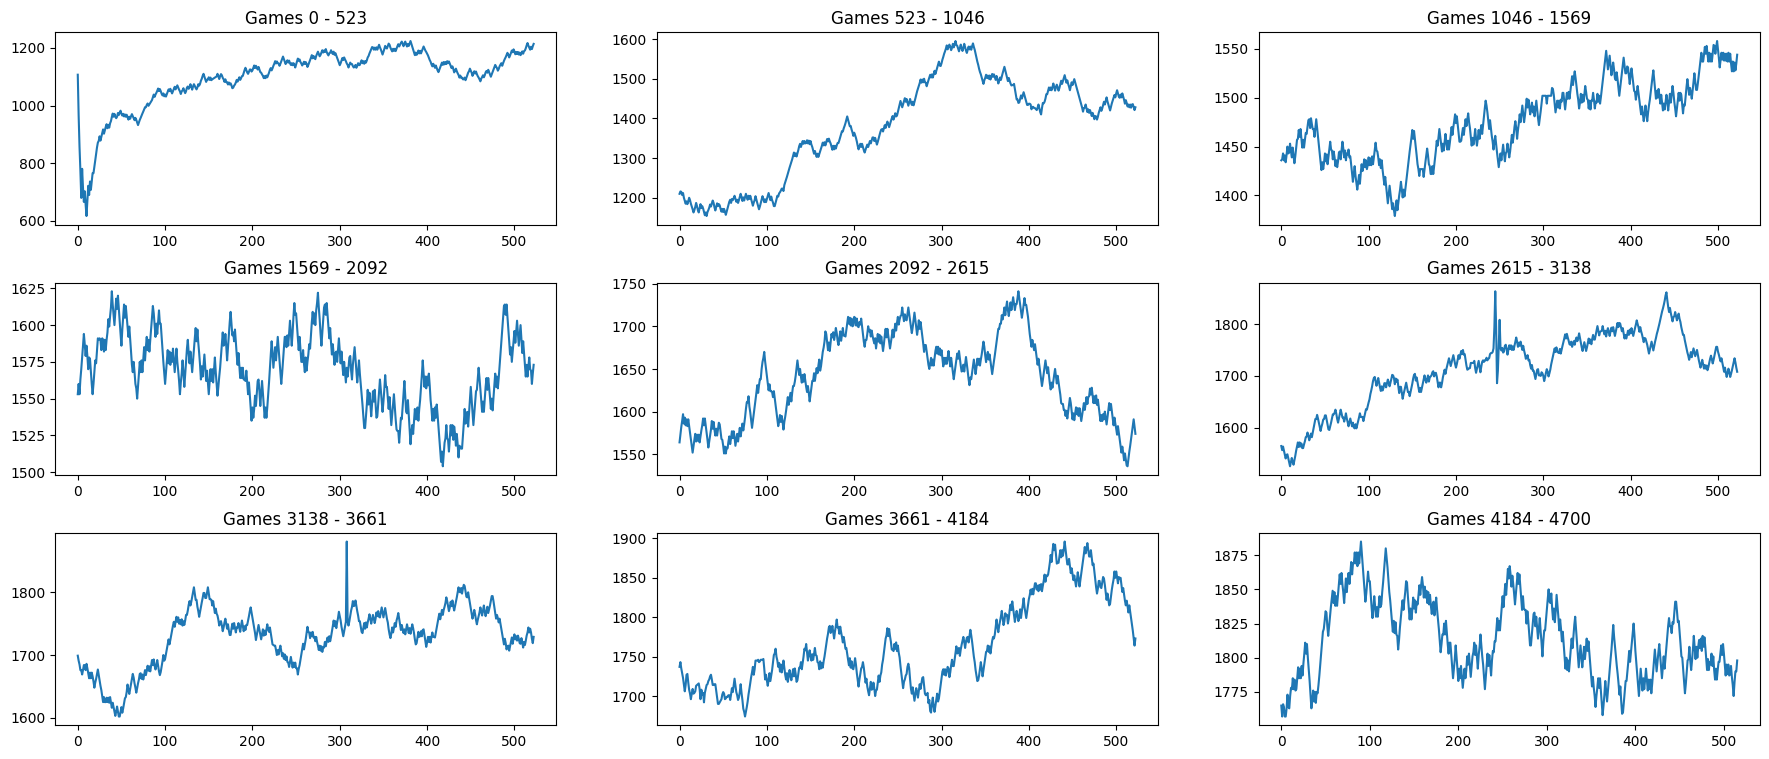

In [41]:
import math

time_class = 'blitz'
is_rated = True
NUM_GAMES = len(df[(df['time_class'] == time_class)&(df['is_rated'] == is_rated)])
num_buckets = 9
if num_buckets is None:
    bucket_size = 100
    num_buckets = math.ceil(NUM_GAMES/bucket_size)
else:
    bucket_size = math.ceil(NUM_GAMES/num_buckets)

num_cols = 2 if num_buckets <=4 else 3
num_rows = math.ceil((NUM_GAMES/bucket_size)/num_cols)

fig,ax = plt.subplots(ncols = num_cols, nrows= num_rows)
x,y = 0,0
fig.set_size_inches(w = 22, h = num_rows*3)

for i in range(num_buckets):
    df_rest = getRestrictedDF(df,num_games=(i*bucket_size,(i+1)*bucket_size),time_class=time_class)
    ax[x,y].plot(np.arange(len(df_rest)),df_rest['player_rating'])
    ax[x,y].set_title("Games {:.0f} - {:.0f}".format(i*bucket_size,i*bucket_size + len(df_rest)))
    y += 1
    if y==num_cols:
        x +=1
        y = 0

plt.subplots_adjust(hspace=0.3)
plt.show()

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(getRestrictedDF(df,num_games=300,time_class='blitz')['player_rating'])


ModuleNotFoundError: No module named 'statsmodels'

In [44]:
print(data_json_list[1]['pgn'])

[Event "Live Chess"]
[Site "Chess.com"]
[Date "2018.09.07"]
[Round "-"]
[White "WVMLL"]
[Black "rohitg1234"]
[Result "1-0"]
[CurrentPosition "2R5/6k1/2p3p1/p1P4p/Pn5P/5NP1/4rPK1/8 b - -"]
[Timezone "UTC"]
[ECO "C42"]
[ECOUrl "https://www.chess.com/openings/Petrovs-Defense-Three-Knights-Game"]
[UTCDate "2018.09.07"]
[UTCTime "17:35:17"]
[WhiteElo "1186"]
[BlackElo "966"]
[TimeControl "600"]
[Termination "WVMLL won on time"]
[StartTime "17:35:17"]
[EndDate "2018.09.07"]
[EndTime "17:51:09"]
[Link "https://www.chess.com/game/live/3059517172"]

1. e4 {[%clk 0:09:55.4]} 1... e5 {[%clk 0:09:57.1]} 2. Nf3 {[%clk 0:09:48.4]} 2... Nf6 {[%clk 0:09:51.3]} 3. Nc3 {[%clk 0:09:42.4]} 3... g6 {[%clk 0:09:32.6]} 4. Nxe5 {[%clk 0:09:36.2]} 4... d6 {[%clk 0:09:26.8]} 5. Nf3 {[%clk 0:09:33.3]} 5... Bg7 {[%clk 0:09:23.7]} 6. d3 {[%clk 0:09:26.9]} 6... O-O {[%clk 0:09:21.2]} 7. Nd5 {[%clk 0:09:19.6]} 7... Be6 {[%clk 0:09:11.1]} 8. Bg5 {[%clk 0:09:10.1]} 8... Nc6 {[%clk 0:08:58.5]} 9. Nxf6+ {[%clk 0:08:56.7

In [45]:
data_json_list[1]

{'url': 'https://www.chess.com/game/live/3059517172',
 'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2018.09.07"]\n[Round "-"]\n[White "WVMLL"]\n[Black "rohitg1234"]\n[Result "1-0"]\n[CurrentPosition "2R5/6k1/2p3p1/p1P4p/Pn5P/5NP1/4rPK1/8 b - -"]\n[Timezone "UTC"]\n[ECO "C42"]\n[ECOUrl "https://www.chess.com/openings/Petrovs-Defense-Three-Knights-Game"]\n[UTCDate "2018.09.07"]\n[UTCTime "17:35:17"]\n[WhiteElo "1186"]\n[BlackElo "966"]\n[TimeControl "600"]\n[Termination "WVMLL won on time"]\n[StartTime "17:35:17"]\n[EndDate "2018.09.07"]\n[EndTime "17:51:09"]\n[Link "https://www.chess.com/game/live/3059517172"]\n\n1. e4 {[%clk 0:09:55.4]} 1... e5 {[%clk 0:09:57.1]} 2. Nf3 {[%clk 0:09:48.4]} 2... Nf6 {[%clk 0:09:51.3]} 3. Nc3 {[%clk 0:09:42.4]} 3... g6 {[%clk 0:09:32.6]} 4. Nxe5 {[%clk 0:09:36.2]} 4... d6 {[%clk 0:09:26.8]} 5. Nf3 {[%clk 0:09:33.3]} 5... Bg7 {[%clk 0:09:23.7]} 6. d3 {[%clk 0:09:26.9]} 6... O-O {[%clk 0:09:21.2]} 7. Nd5 {[%clk 0:09:19.6]} 7... Be6 {[%clk 0:09:1

In [46]:
df.columns

Index(['URL', 'game_id', 'is_rated', 'time_control', 'time_class',
       'start_time', 'end_time', 'num_moves', 'duration', 'white_username',
       'white_rating', 'white_result', 'black_rating', 'black_username',
       'black_result', 'player_colour', 'player_rating', 'opponent_colour',
       'opponent_rating', 'rating_difference', 'player_result',
       'player_result_value', 'result_method'],
      dtype='object')

In [47]:
def getExpectedScore(r1,r2):
    d = r2-r1
    E1 = 1/(1+10**(d/400))
    E2 = 1/(1+10**(-d/400))
    return (E1,E2)

def getExpectedScoreFromDifference(d):
    E1 = 1/(1+10**(d/400))
    E2 = 1/(1+10**(-d/400))
    return (E1,E2)

def updateRating(r1,r2,result,K=16):
    E = getExpectedScore(r1,r2)
    r1 = r1 + K*(result - E[0])
    r2 = r2 + K*((1-result) - E[1])
    return (r1,r2)

def getOriginalRating(r1,r2,result,K=16): # takes the post-game rating and estimates the pre-game rating
    pass


In [48]:
getExpectedScore(1500,1500)

(0.5, 0.5)

In [49]:
updateRating(1500,1500,1)

(1508.0, 1492.0)

In [50]:
df_blitz_rating = getRestrictedDF(df,num_games=2000,time_class='blitz')[['game_id','player_rating','opponent_rating','player_result','player_result_value']]
df_blitz_rating['game_number'] = np.arange(1,len(df_blitz_rating)+1)
df_blitz_rating['prev_game_number'] = np.arange(len(df_blitz_rating))

In [51]:
K = 16

df_change = df_blitz_rating.merge(df_blitz_rating,how='left',left_on='prev_game_number',right_on='game_number',suffixes=('','_prev'))[['game_id','player_rating_prev','player_result','player_result_value','player_rating','opponent_rating']].iloc[1:]

df_change['player_rating_change'] = df_change['player_rating'] - df_change['player_rating_prev']
df_change['opponent_rating_change'] =-df_change['player_rating_change']
df_change['opponent_rating_prev'] = df_change['opponent_rating'] - df_change['opponent_rating_change']
df_change['difference'] = df_change['opponent_rating_prev'] - df_change['player_rating_prev'] 
df_change['expected_score'] = getExpectedScoreFromDifference(df_change['difference'])[0]

df_change = df_change[['game_id','player_rating_prev','opponent_rating_prev','difference','expected_score','player_result_value','player_rating_change','player_rating','opponent_rating']]

df_change = df_change[np.abs(df_change['player_rating_change']) <= 20]
df_change = df_change[np.abs(df_change['difference']) <= 400]

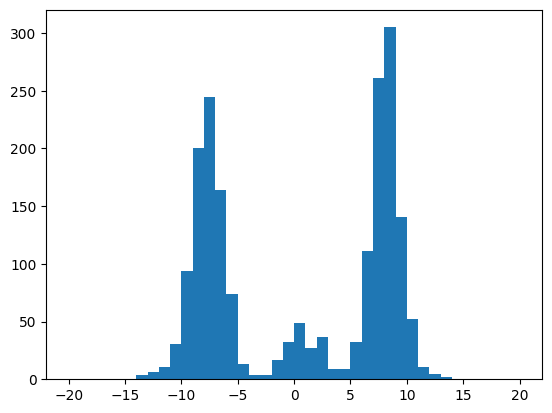

In [52]:
plt.hist(df_change['player_rating_change'],bins=np.arange(-20,21))
plt.show()

In [53]:
c_list = np.arange(20,75)

MSEs = []

for c in c_list:
    penalty = np.sign(df_change['difference'])*np.floor(np.abs(df_change['difference'])/c)
    heuristic_val = K*(df_change['player_result_value'] - 0.5) + penalty
    heuristic_val =  np.where(df_change['player_result_value'] == 1,np.maximum(0,heuristic_val) ,heuristic_val)
    heuristic_error = df_change['player_rating_change'] - heuristic_val
    MSEs.append(np.mean(np.square(heuristic_error)))

lin_penalty = pd.Series(data=MSEs,index=c_list)
min_index = np.argmin(lin_penalty)
best_C_linear = c_list[min_index]
MSE_C_linear = MSEs[min_index]

In [54]:
c_list = np.linspace(start=2,stop=6,num=1000)

MSEs = []

for c in c_list:
    penalty = np.sign(df_change['difference'])*np.floor(np.sqrt(np.abs(df_change['difference']))/c)
    heuristic_val = K*(df_change['player_result_value'] - 0.5) + penalty
    heuristic_val =  np.where(df_change['player_result_value'] == 1,np.maximum(0,heuristic_val) ,heuristic_val)
    heuristic_error = df_change['player_rating_change'] - heuristic_val
    MSEs.append(np.mean(np.square(heuristic_error)))

sqrt_penalty = pd.Series(data=MSEs,index=c_list)
min_index = np.argmin(sqrt_penalty)
best_C_sqrt = c_list[min_index]
MSE_C_sqrt = MSEs[min_index]

In [146]:
c_list = np.arange(1,5, step = 0.1)

MSEs = []

for c in c_list:
    penalty = np.sign(df_change['difference'])*np.floor(np.log(1 + np.abs(df_change['difference']))/c)
    heuristic_val = K*(df_change['player_result_value'] - 0.5) + penalty
    heuristic_val =  np.where(df_change['player_result_value'] == 1,np.maximum(0,heuristic_val) ,heuristic_val)
    heuristic_error = df_change['player_rating_change'] - heuristic_val
    print(heuristic_error.shape)
    MSEs.append(np.mean(np.square(heuristic_error)))

log_penalty = pd.Series(data=MSEs,index=c_list)
min_index = np.argmin(log_penalty)
best_C_log = c_list[min_index]
MSE_C_log = MSEs[min_index]

(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)
(1950,)


In [56]:
crit_val = best_C_sqrt
K = 16

#penalty = np.sign(df_change['difference'])*np.floor(np.abs(df_change['difference'])/crit_val) # c = 30:MSE = 1.008008008008008, 32: MSE = 0.8
penalty = np.sign(df_change['difference'])*np.floor(np.sqrt(np.abs(df_change['difference']))/crit_val) #  MSE = 0.82 

heuristic_val = K*(df_change['player_result_value'] - 0.5) + penalty

df_change['sqrt_heuristic'] =  np.where(df_change['player_result_value'] == 1,np.maximum(0,heuristic_val) ,heuristic_val)
df_change['sqrt_heuristic_error'] = df_change['player_rating_change'] - df_change['sqrt_heuristic']

In [57]:
## custom heuristic

def penalty_value(x):
    if -21<=x<=21:
        return 0
    elif 22 <= abs(x) <= 66:
        return 1
    elif 67 <= abs(x) <= 112:
        return 2
    elif 113 <= abs(x) <= 161:
        return 3
    else:
        return 4
    
penalty = np.sign(df_change['difference']) * np.array([penalty_value(x) for x in df_change['difference']])
heuristic_val = K*(df_change['player_result_value'] - 0.5) + penalty

df_change['custom_heuristic'] =  np.where(df_change['player_result_value'] == 1,np.maximum(0,heuristic_val) ,heuristic_val)
df_change['custom_heuristic_error'] = df_change['player_rating_change'] - df_change['custom_heuristic']


np.mean(np.square(df_change['custom_heuristic_error']))

0.16205128205128205

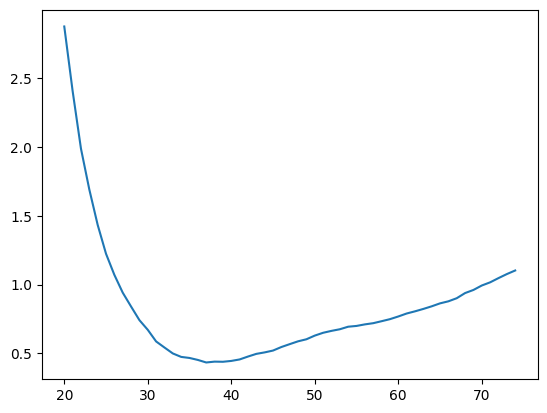

37 0.43435897435897436


In [58]:
plt.plot(lin_penalty)
plt.show()
print(best_C_linear,MSE_C_linear)

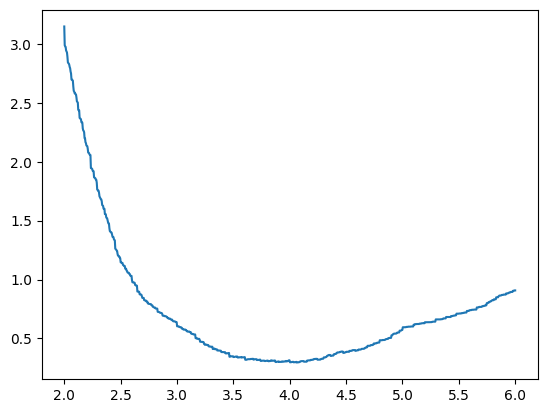

4.062062062062062 0.2958974358974359


In [59]:
plt.plot(sqrt_penalty)
plt.show()
print(best_C_sqrt,MSE_C_sqrt)

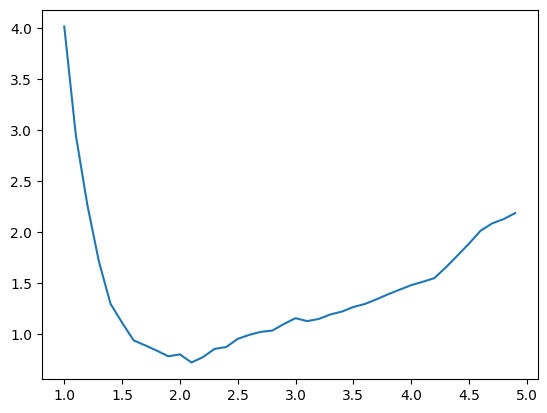

2.100000000000001 0.7194871794871794


In [60]:
plt.plot(log_penalty)
plt.show()
print(best_C_log,MSE_C_log)

In [61]:
df_change.sort_values(by=['sqrt_heuristic_error'],ascending=False)

,game_id,player_rating_prev,opponent_rating_prev,difference,expected_score,player_result_value,player_rating_change,player_rating,opponent_rating,sqrt_heuristic,sqrt_heuristic_error,custom_heuristic,custom_heuristic_error
969,60036560961,1714.0,1606.0,-108.0,0.650605,1.0,13.0,1727,1593,6.0,7.0,6.0,7.0
1313,68249565061,1756.0,1855.0,99.0,0.361262,0.0,1.0,1757,1854,-6.0,7.0,-6.0,7.0
1388,79926656747,1870.0,2018.0,148.0,0.299023,1.0,13.0,1883,2005,10.0,3.0,11.0,2.0
1052,60649176223,1746.0,1981.0,235.0,0.205418,0.0,-3.0,1743,1984,-5.0,2.0,-4.0,1.0
214,32136645599,1707.0,2016.0,309.0,0.144458,0.0,-2.0,1705,2018,-4.0,2.0,-4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,31522174207,1713.0,1405.0,-308.0,0.854829,1.0,2.0,1715,1403,4.0,-2.0,4.0,-2.0
92,30903539399,1705.0,1307.0,-398.0,0.908135,1.0,1.0,1706,1306,4.0,-3.0,4.0,-3.0
1392,82341704435,1892.0,1860.0,-32.0,0.545922,0.0,-12.0,1880,1872,-9.0,-3.0,-9.0,-3.0
1393,82342233173,1880.0,1827.0,-53.0,0.575687,0.0,-12.0,1868,1839,-9.0,-3.0,-9.0,-3.0


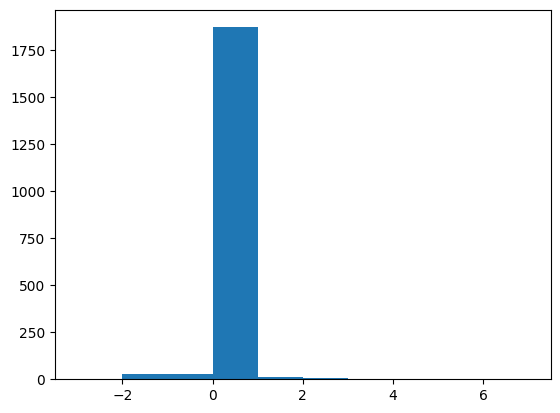

In [62]:
plt.hist(df_change['custom_heuristic_error'])
plt.show()

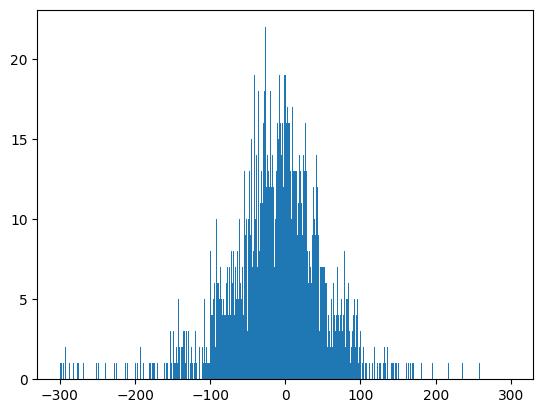

-16.50051282051282

In [63]:
plt.hist(df_change['difference'],bins=np.arange(-300,301))
plt.show()
np.mean(df_change['difference'])

  0%|                                          | 0/100 [00:00<?, ?it/s]

  1%|▎                                 | 1/100 [00:01<02:33,  1.56s/it]

updates 2000, counter -14433.0, cost 0.9019508957862854, with y tensor([[-1.0503]], grad_fn=<AddmmBackward0>), t tensor([-2.])


  2%|▋                                 | 2/100 [00:02<02:24,  1.48s/it]

updates 4000, counter -27546.0, cost 0.006488218437880278, with y tensor([[0.9195]], grad_fn=<AddmmBackward0>), t tensor([1.])


  3%|█                                 | 3/100 [00:04<02:19,  1.44s/it]

updates 6000, counter -40836.0, cost 0.0003025784099008888, with y tensor([[1.0174]], grad_fn=<AddmmBackward0>), t tensor([1.])


  4%|█▎                                | 4/100 [00:05<02:17,  1.44s/it]

updates 8000, counter -54284.0, cost 0.8760460019111633, with y tensor([[0.9360]], grad_fn=<AddmmBackward0>), t tensor([0.])


  5%|█▋                                | 5/100 [00:07<02:15,  1.43s/it]

updates 10000, counter -67163.0, cost 1.0900373458862305, with y tensor([[1.0440]], grad_fn=<AddmmBackward0>), t tensor([0.])


  6%|██                                | 6/100 [00:08<02:12,  1.41s/it]

updates 12000, counter -75577.0, cost 0.00526813231408596, with y tensor([[0.0726]], grad_fn=<AddmmBackward0>), t tensor([0.])


  7%|██▍                               | 7/100 [00:10<02:15,  1.46s/it]

updates 14000, counter -77494.0, cost 0.2255888432264328, with y tensor([[0.4750]], grad_fn=<AddmmBackward0>), t tensor([0.])


  8%|██▋                               | 8/100 [00:11<02:15,  1.47s/it]

updates 16000, counter -78978.0, cost 0.10322260111570358, with y tensor([[0.3213]], grad_fn=<AddmmBackward0>), t tensor([0.])


  9%|███                               | 9/100 [00:13<02:11,  1.45s/it]

updates 18000, counter -80478.0, cost 0.393656849861145, with y tensor([[-0.6274]], grad_fn=<AddmmBackward0>), t tensor([0.])


 10%|███▎                             | 10/100 [00:14<02:09,  1.44s/it]

updates 20000, counter -80833.0, cost 0.13314524292945862, with y tensor([[-0.3649]], grad_fn=<AddmmBackward0>), t tensor([0.])


 11%|███▋                             | 11/100 [00:15<02:07,  1.44s/it]

updates 22000, counter -81582.0, cost 0.05203301087021828, with y tensor([[-2.2281]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 12%|███▉                             | 12/100 [00:17<02:04,  1.42s/it]

updates 24000, counter -82702.0, cost 0.07453827559947968, with y tensor([[0.2730]], grad_fn=<AddmmBackward0>), t tensor([0.])


 13%|████▎                            | 13/100 [00:18<02:03,  1.42s/it]

updates 26000, counter -83981.0, cost 0.02248363383114338, with y tensor([[-0.1499]], grad_fn=<AddmmBackward0>), t tensor([0.])


 14%|████▌                            | 14/100 [00:20<02:01,  1.41s/it]

updates 28000, counter -84534.0, cost 0.22369882464408875, with y tensor([[-1.4730]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 15%|████▉                            | 15/100 [00:21<01:59,  1.40s/it]

updates 30000, counter -85634.0, cost 0.2619505226612091, with y tensor([[-1.4882]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 16%|█████▎                           | 16/100 [00:22<01:57,  1.40s/it]

updates 32000, counter -86558.0, cost 0.03713448345661163, with y tensor([[0.1927]], grad_fn=<AddmmBackward0>), t tensor([0.])


 17%|█████▌                           | 17/100 [00:24<01:55,  1.39s/it]

updates 34000, counter -88504.0, cost 0.10532061755657196, with y tensor([[-0.3245]], grad_fn=<AddmmBackward0>), t tensor([0.])


 18%|█████▉                           | 18/100 [00:25<01:54,  1.40s/it]

updates 36000, counter -88999.0, cost 0.0058658914640545845, with y tensor([[-1.0766]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 19%|██████▎                          | 19/100 [00:27<01:54,  1.41s/it]

updates 38000, counter -89517.0, cost 0.10547545552253723, with y tensor([[1.3248]], grad_fn=<AddmmBackward0>), t tensor([1.])


 20%|██████▌                          | 20/100 [00:28<01:52,  1.41s/it]

updates 40000, counter -89787.0, cost 0.08559545874595642, with y tensor([[-0.7074]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 21%|██████▉                          | 21/100 [00:29<01:52,  1.42s/it]

updates 42000, counter -91195.0, cost 0.2070058435201645, with y tensor([[0.5450]], grad_fn=<AddmmBackward0>), t tensor([1.])


 22%|███████▎                         | 22/100 [00:31<01:50,  1.41s/it]

updates 44000, counter -92540.0, cost 6.688351277261972e-05, with y tensor([[-1.0082]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 23%|███████▌                         | 23/100 [00:32<01:48,  1.41s/it]

updates 46000, counter -93489.0, cost 0.03370482847094536, with y tensor([[-1.8164]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 24%|███████▉                         | 24/100 [00:34<01:47,  1.42s/it]

updates 48000, counter -93730.0, cost 0.012671640142798424, with y tensor([[-1.8874]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 25%|████████▎                        | 25/100 [00:35<01:46,  1.42s/it]

updates 50000, counter -94916.0, cost 0.03270692750811577, with y tensor([[-0.8191]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 26%|████████▌                        | 26/100 [00:37<01:44,  1.41s/it]

updates 52000, counter -94969.0, cost 0.1529313623905182, with y tensor([[-1.6089]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 27%|████████▉                        | 27/100 [00:38<01:42,  1.40s/it]

updates 54000, counter -95508.0, cost 0.00976256001740694, with y tensor([[0.9012]], grad_fn=<AddmmBackward0>), t tensor([1.])


 28%|█████████▏                       | 28/100 [00:39<01:41,  1.40s/it]

updates 56000, counter -96933.0, cost 0.009050731547176838, with y tensor([[0.9049]], grad_fn=<AddmmBackward0>), t tensor([1.])


 29%|█████████▌                       | 29/100 [00:41<01:39,  1.41s/it]

updates 58000, counter -97024.0, cost 0.08544039726257324, with y tensor([[-0.2923]], grad_fn=<AddmmBackward0>), t tensor([0.])


 30%|█████████▉                       | 30/100 [00:42<01:38,  1.41s/it]

updates 60000, counter -97633.0, cost 0.0368020124733448, with y tensor([[0.8082]], grad_fn=<AddmmBackward0>), t tensor([1.])


 31%|██████████▏                      | 31/100 [00:44<01:37,  1.41s/it]

updates 62000, counter -98891.0, cost 0.03194595128297806, with y tensor([[1.1787]], grad_fn=<AddmmBackward0>), t tensor([1.])


 32%|██████████▌                      | 32/100 [00:45<01:36,  1.41s/it]

updates 64000, counter -99437.0, cost 0.0298031996935606, with y tensor([[-2.1726]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 33%|██████████▉                      | 33/100 [00:46<01:35,  1.43s/it]

updates 66000, counter -99513.0, cost 0.30035141110420227, with y tensor([[-1.5480]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 35%|███████████▌                     | 35/100 [00:49<01:32,  1.42s/it]

updates 68000, counter -100648.0, cost 1.2217069524922408e-06, with y tensor([[0.0011]], grad_fn=<AddmmBackward0>), t tensor([0.])


 36%|███████████▉                     | 36/100 [00:51<01:30,  1.41s/it]

updates 70000, counter -101328.0, cost 0.07343823462724686, with y tensor([[2.7290]], grad_fn=<AddmmBackward0>), t tensor([3.])


 37%|████████████▏                    | 37/100 [00:52<01:29,  1.42s/it]

updates 72000, counter -102166.0, cost 0.0044823894277215, with y tensor([[-0.0670]], grad_fn=<AddmmBackward0>), t tensor([0.])


 38%|████████████▌                    | 38/100 [00:53<01:27,  1.41s/it]

updates 74000, counter -102509.0, cost 0.11623749881982803, with y tensor([[-0.3409]], grad_fn=<AddmmBackward0>), t tensor([0.])


 39%|████████████▊                    | 39/100 [00:55<01:25,  1.40s/it]

updates 76000, counter -103204.0, cost 0.06074662506580353, with y tensor([[-1.2465]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 40%|█████████████▏                   | 40/100 [00:56<01:24,  1.40s/it]

updates 78000, counter -104017.0, cost 0.19222654402256012, with y tensor([[0.4384]], grad_fn=<AddmmBackward0>), t tensor([0.])


 41%|█████████████▌                   | 41/100 [00:58<01:22,  1.40s/it]

updates 80000, counter -104681.0, cost 0.013319103978574276, with y tensor([[-1.1154]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 42%|█████████████▊                   | 42/100 [00:59<01:20,  1.40s/it]

updates 82000, counter -104983.0, cost 0.031803227961063385, with y tensor([[0.8217]], grad_fn=<AddmmBackward0>), t tensor([1.])


 43%|██████████████▏                  | 43/100 [01:00<01:19,  1.39s/it]

updates 84000, counter -105418.0, cost 0.07518123835325241, with y tensor([[-1.2742]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 44%|██████████████▌                  | 44/100 [01:02<01:18,  1.40s/it]

updates 86000, counter -105902.0, cost 0.18956725299358368, with y tensor([[-1.4354]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 45%|██████████████▊                  | 45/100 [01:03<01:16,  1.39s/it]

updates 88000, counter -106509.0, cost 0.07513738423585892, with y tensor([[-0.7259]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 46%|███████████████▏                 | 46/100 [01:05<01:15,  1.39s/it]

updates 90000, counter -107086.0, cost 0.10298698395490646, with y tensor([[0.3209]], grad_fn=<AddmmBackward0>), t tensor([0.])


 47%|███████████████▌                 | 47/100 [01:06<01:13,  1.39s/it]

updates 92000, counter -107652.0, cost 0.07534047216176987, with y tensor([[-0.7255]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 48%|███████████████▊                 | 48/100 [01:07<01:12,  1.39s/it]

updates 94000, counter -108243.0, cost 0.0026080571115016937, with y tensor([[-0.9489]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 49%|████████████████▏                | 49/100 [01:09<01:10,  1.39s/it]

updates 96000, counter -108581.0, cost 0.12931598722934723, with y tensor([[0.6404]], grad_fn=<AddmmBackward0>), t tensor([1.])


 50%|████████████████▌                | 50/100 [01:10<01:09,  1.39s/it]

updates 98000, counter -109235.0, cost 3.7086939811706543, with y tensor([[0.0742]], grad_fn=<AddmmBackward0>), t tensor([2.])


 51%|████████████████▊                | 51/100 [01:12<01:08,  1.39s/it]

updates 100000, counter -110185.0, cost 0.0007358012371696532, with y tensor([[0.9729]], grad_fn=<AddmmBackward0>), t tensor([1.])


 52%|█████████████████▏               | 52/100 [01:13<01:07,  1.40s/it]

updates 102000, counter -110270.0, cost 0.15390032529830933, with y tensor([[-1.3923]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 53%|█████████████████▍               | 53/100 [01:14<01:05,  1.40s/it]

updates 104000, counter -111347.0, cost 0.006000998895615339, with y tensor([[-0.0775]], grad_fn=<AddmmBackward0>), t tensor([0.])


 54%|█████████████████▊               | 54/100 [01:16<01:04,  1.40s/it]

updates 106000, counter -111612.0, cost 0.012166104279458523, with y tensor([[-1.1103]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 55%|██████████████████▏              | 55/100 [01:17<01:03,  1.40s/it]

updates 108000, counter -111776.0, cost 0.043808478862047195, with y tensor([[0.7907]], grad_fn=<AddmmBackward0>), t tensor([1.])


 56%|██████████████████▍              | 56/100 [01:19<01:01,  1.40s/it]

updates 110000, counter -111888.0, cost 0.002141388365998864, with y tensor([[0.9537]], grad_fn=<AddmmBackward0>), t tensor([1.])


 57%|██████████████████▊              | 57/100 [01:20<01:00,  1.40s/it]

updates 112000, counter -113117.0, cost 0.051116883754730225, with y tensor([[-1.2261]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 58%|███████████████████▏             | 58/100 [01:21<00:58,  1.40s/it]

updates 114000, counter -113274.0, cost 7.200641448434908e-06, with y tensor([[1.0027]], grad_fn=<AddmmBackward0>), t tensor([1.])


 59%|███████████████████▍             | 59/100 [01:23<00:57,  1.40s/it]

updates 116000, counter -113864.0, cost 0.0523470938205719, with y tensor([[0.2288]], grad_fn=<AddmmBackward0>), t tensor([0.])


 60%|███████████████████▊             | 60/100 [01:24<00:56,  1.42s/it]

updates 118000, counter -114169.0, cost 0.19215863943099976, with y tensor([[-2.5616]], grad_fn=<AddmmBackward0>), t tensor([-3.])


 61%|████████████████████▏            | 61/100 [01:26<00:54,  1.41s/it]

updates 120000, counter -114260.0, cost 0.005874883383512497, with y tensor([[0.0766]], grad_fn=<AddmmBackward0>), t tensor([0.])


 62%|████████████████████▍            | 62/100 [01:27<00:53,  1.41s/it]

updates 122000, counter -114968.0, cost 0.2311747521162033, with y tensor([[-1.4808]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 63%|████████████████████▊            | 63/100 [01:28<00:51,  1.40s/it]

updates 124000, counter -115558.0, cost 0.006401051301509142, with y tensor([[0.0800]], grad_fn=<AddmmBackward0>), t tensor([0.])


 64%|█████████████████████            | 64/100 [01:30<00:50,  1.41s/it]

updates 126000, counter -115537.0, cost 0.012392955832183361, with y tensor([[0.1113]], grad_fn=<AddmmBackward0>), t tensor([0.])


 65%|█████████████████████▍           | 65/100 [01:31<00:49,  1.41s/it]

updates 128000, counter -115803.0, cost 0.08945969492197037, with y tensor([[-1.2991]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 66%|█████████████████████▊           | 66/100 [01:33<00:47,  1.41s/it]

updates 130000, counter -116485.0, cost 0.017771132290363312, with y tensor([[1.8667]], grad_fn=<AddmmBackward0>), t tensor([2.])


 67%|██████████████████████           | 67/100 [01:34<00:46,  1.41s/it]

updates 132000, counter -116632.0, cost 0.15444554388523102, with y tensor([[1.3930]], grad_fn=<AddmmBackward0>), t tensor([1.])


 68%|██████████████████████▍          | 68/100 [01:35<00:44,  1.40s/it]

updates 134000, counter -117375.0, cost 0.20368145406246185, with y tensor([[-0.4513]], grad_fn=<AddmmBackward0>), t tensor([0.])


 69%|██████████████████████▊          | 69/100 [01:37<00:43,  1.40s/it]

updates 136000, counter -117655.0, cost 0.042393822222948074, with y tensor([[0.2059]], grad_fn=<AddmmBackward0>), t tensor([0.])


 70%|███████████████████████          | 70/100 [01:38<00:41,  1.40s/it]

updates 138000, counter -117942.0, cost 0.010840928182005882, with y tensor([[1.1041]], grad_fn=<AddmmBackward0>), t tensor([1.])


 71%|███████████████████████▍         | 71/100 [01:40<00:40,  1.40s/it]

updates 140000, counter -118079.0, cost 0.1145688071846962, with y tensor([[-0.3385]], grad_fn=<AddmmBackward0>), t tensor([0.])


 72%|███████████████████████▊         | 72/100 [01:41<00:39,  1.40s/it]

updates 142000, counter -118797.0, cost 0.2780537009239197, with y tensor([[1.5273]], grad_fn=<AddmmBackward0>), t tensor([1.])


 73%|████████████████████████         | 73/100 [01:42<00:37,  1.40s/it]

updates 144000, counter -118972.0, cost 0.25299176573753357, with y tensor([[-1.5030]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 75%|████████████████████████▊        | 75/100 [01:45<00:34,  1.40s/it]

updates 146000, counter -119211.0, cost 0.3235107660293579, with y tensor([[-1.5688]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 76%|█████████████████████████        | 76/100 [01:47<00:33,  1.39s/it]

updates 148000, counter -119761.0, cost 0.06572316586971283, with y tensor([[-0.7436]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 77%|█████████████████████████▍       | 77/100 [01:48<00:32,  1.39s/it]

updates 150000, counter -120305.0, cost 0.039252620190382004, with y tensor([[0.8019]], grad_fn=<AddmmBackward0>), t tensor([1.])


 78%|█████████████████████████▋       | 78/100 [01:49<00:30,  1.40s/it]

updates 152000, counter -120601.0, cost 0.03043052926659584, with y tensor([[0.8256]], grad_fn=<AddmmBackward0>), t tensor([1.])


 79%|██████████████████████████       | 79/100 [01:51<00:29,  1.40s/it]

updates 154000, counter -120792.0, cost 0.37766480445861816, with y tensor([[0.3855]], grad_fn=<AddmmBackward0>), t tensor([1.])


 80%|██████████████████████████▍      | 80/100 [01:52<00:27,  1.40s/it]

updates 156000, counter -121181.0, cost 3.9020090103149414, with y tensor([[-0.0246]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 81%|██████████████████████████▋      | 81/100 [01:54<00:26,  1.40s/it]

updates 158000, counter -121305.0, cost 0.03519193083047867, with y tensor([[-2.1876]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 82%|███████████████████████████      | 82/100 [01:55<00:25,  1.40s/it]

updates 160000, counter -121886.0, cost 0.06104857102036476, with y tensor([[-2.2471]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 83%|███████████████████████████▍     | 83/100 [01:56<00:23,  1.40s/it]

updates 162000, counter -122296.0, cost 0.13727402687072754, with y tensor([[-1.6295]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 84%|███████████████████████████▋     | 84/100 [01:58<00:22,  1.40s/it]

updates 164000, counter -122342.0, cost 0.10017485916614532, with y tensor([[-1.6835]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 85%|████████████████████████████     | 85/100 [01:59<00:20,  1.40s/it]

updates 166000, counter -122662.0, cost 0.0403134822845459, with y tensor([[-1.7992]], grad_fn=<AddmmBackward0>), t tensor([-2.])


 86%|████████████████████████████▍    | 86/100 [02:01<00:19,  1.40s/it]

updates 168000, counter -122986.0, cost 0.1042952612042427, with y tensor([[0.3229]], grad_fn=<AddmmBackward0>), t tensor([0.])


 87%|████████████████████████████▋    | 87/100 [02:02<00:18,  1.40s/it]

updates 170000, counter -123432.0, cost 0.045789819210767746, with y tensor([[-1.2140]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 88%|█████████████████████████████    | 88/100 [02:03<00:16,  1.39s/it]

updates 172000, counter -123652.0, cost 0.0006383974687196314, with y tensor([[-1.0253]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 89%|█████████████████████████████▎   | 89/100 [02:05<00:15,  1.40s/it]

updates 174000, counter -123831.0, cost 0.0263063944876194, with y tensor([[-1.1622]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 90%|█████████████████████████████▋   | 90/100 [02:06<00:14,  1.41s/it]

updates 176000, counter -124181.0, cost 0.13793513178825378, with y tensor([[0.6286]], grad_fn=<AddmmBackward0>), t tensor([1.])


 91%|██████████████████████████████   | 91/100 [02:08<00:12,  1.41s/it]

updates 178000, counter -124991.0, cost 0.0012023970484733582, with y tensor([[-1.0347]], grad_fn=<AddmmBackward0>), t tensor([-1.])


 92%|██████████████████████████████▎  | 92/100 [02:09<00:11,  1.40s/it]

updates 180000, counter -124953.0, cost 0.009149513207376003, with y tensor([[0.0957]], grad_fn=<AddmmBackward0>), t tensor([0.])


 93%|██████████████████████████████▋  | 93/100 [02:10<00:09,  1.40s/it]

updates 182000, counter -125516.0, cost 0.0012662360677495599, with y tensor([[3.9644]], grad_fn=<AddmmBackward0>), t tensor([4.])


 94%|███████████████████████████████  | 94/100 [02:12<00:08,  1.40s/it]

updates 184000, counter -125505.0, cost 0.17986731231212616, with y tensor([[1.4241]], grad_fn=<AddmmBackward0>), t tensor([1.])


 95%|███████████████████████████████▎ | 95/100 [02:13<00:07,  1.41s/it]

updates 186000, counter -125329.0, cost 0.1395714432001114, with y tensor([[1.3736]], grad_fn=<AddmmBackward0>), t tensor([1.])


 96%|███████████████████████████████▋ | 96/100 [02:15<00:05,  1.42s/it]

updates 188000, counter -125538.0, cost 8.992974471766502e-06, with y tensor([[1.0030]], grad_fn=<AddmmBackward0>), t tensor([1.])


 97%|████████████████████████████████ | 97/100 [02:16<00:04,  1.42s/it]

updates 190000, counter -125917.0, cost 0.0016917214961722493, with y tensor([[-3.0411]], grad_fn=<AddmmBackward0>), t tensor([-3.])


 98%|████████████████████████████████▎| 98/100 [02:17<00:02,  1.41s/it]

updates 192000, counter -126673.0, cost 0.23447977006435394, with y tensor([[0.5158]], grad_fn=<AddmmBackward0>), t tensor([1.])


 99%|████████████████████████████████▋| 99/100 [02:19<00:01,  1.42s/it]

updates 194000, counter -126336.0, cost 0.08468197286128998, with y tensor([[-0.7090]], grad_fn=<AddmmBackward0>), t tensor([-1.])


100%|████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


[0.2675163149833679,
 0.003994797356426716,
 0.012096253223717213,
 5.3026058594696224e-05,
 0.0004696953983511776,
 0.006512053776532412,
 0.004738727584481239,
 0.06696517765522003,
 0.08459201455116272,
 0.11891821771860123,
 0.0002782861120067537,
 0.009230079129338264,
 0.06314059346914291,
 0.16331149637699127,
 0.008512875996530056,
 0.11116129159927368,
 0.028145471587777138,
 0.00012346009316388518,
 0.0009133872226811945,
 0.005436287727206945]

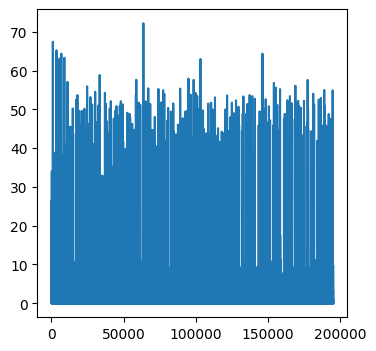

In [140]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

class chess_data(Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]


x = torch.tensor(df_change['difference'].values, dtype=torch.float32).unsqueeze(1) 
t = torch.tensor((df_change['player_rating_change'] - K*(df_change['player_result_value'] - 0.5)).values, dtype=torch.float32) 
ds = chess_data(x, t)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

losses = []
def chess_net_learn(net, dl, epochs = 100, counter = 0):
    for epoch in tqdm(range(epochs)):
        for x, t in dl:
            y = net(x)
            # y = torch.round(y)
            loss = loss_fcn(y, t)
            # print(f"y is {y}, t is {t}")
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())

            if loss.item() < 0.1:
                counter += 1
            else:
                counter -= 5 * np.rint(loss.item())

            if counter >= 100:
                plt.figure(figsize = (4, 4))
                plt.plot(losses);
                return losses[-20:]
            
            if len(losses) % 2000 == 0:
                print(f"updates {len(losses)}, counter {counter}, cost {loss.item()}, with y {y}, t {t}")

    plt.figure(figsize = (4, 4))
    plt.plot(losses);
    return losses[-20:]

chess_net = nn.Sequential(
                nn.Linear(1, 1),
                nn.Tanh(),
                nn.Linear(1, 5),
                nn.LeakyReLU(),
                nn.Linear(5, 5),
                nn.LayerNorm(5),
                nn.Linear(5, 5),
                nn.LeakyReLU(),
                nn.Linear(5, 5),
                nn.LeakyReLU(),
                nn.Linear(5, 5),
                nn.LayerNorm(5),
                nn.Linear(5, 5),
                nn.LeakyReLU(),
                nn.Linear(5, 1)
                )

loss_fcn = nn.MSELoss()
optim = torch.optim.Adam(chess_net.parameters(), lr=0.001) 
chess_net_learn(chess_net, dl)      

# print(x.shape)
# print(t.shape)

# print(t[1:50])

# plt.hist(t,bins=np.arange(-10,10,1))
# plt.show()
# np.mean(df_change['difference'])


In [141]:
x = torch.tensor(df_change['difference'].values, dtype=torch.float32).unsqueeze(1) 
t = torch.tensor((df_change['player_rating_change'] - K*(df_change['player_result_value'] - 0.5)).values, dtype=torch.float32) 


s = 200
e = 230

x_part = x[s:e]
t_part = t[s:e]


y_part = chess_net(x_part)
y_part = torch.round(y_part)
y_part = y_part.flatten()

print("y_part", y_part)
print("t_part", t_part)

y_part tensor([ 2.,  0.,  1., -1., -1.,  1.,  1., -0., -1., -1.,  0., -1.,  0., -1.,
        -1., -1.,  0., -0.,  1.,  1.,  2.,  1., -1., -2., -2., -2., -2.,  1.,
         1., -3.], grad_fn=<ViewBackward0>)
t_part tensor([ 2.,  0.,  1., -1., -1.,  1.,  1.,  0., -2., -1.,  0., -1.,  0., -1.,
        -1., -1.,  0.,  0.,  1.,  1.,  2.,  1., -1., -2., -2., -2., -3.,  1.,
         1., -3.])


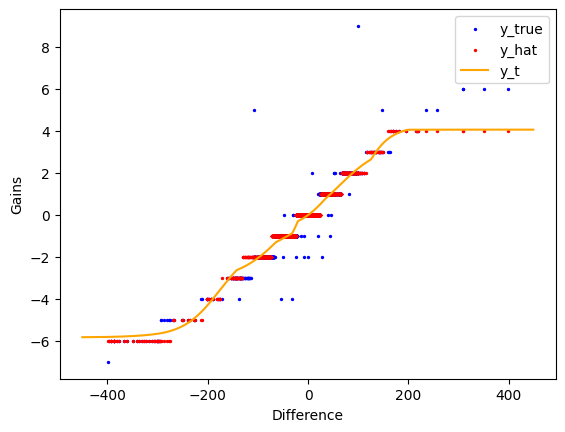

[-2. -1.  1.  0.  1.  0. -0.  0.  1. -1.  0.  1. -2. -0.  2.  0.  2. -0.
  0.  0.]
[-2. -2.  1.  0.  1.  0.  0.  0.  1. -1.  0.  1. -2.  0.  2.  0.  2.  0.
  0.  0.]
mse is 0.15743589401245117


In [157]:
x = torch.tensor(df_change['difference'].values, dtype=torch.float32).unsqueeze(1) 
t = torch.tensor((df_change['player_rating_change'] - K*(df_change['player_result_value'] - 0.5)).values, dtype=torch.float32) 

y = chess_net(x)


y = torch.round(y)
y = y.flatten()
y = y.detach().numpy()

xx = torch.tensor( np.arange(-450, 450, 1), dtype=torch.float32).unsqueeze(1)
yy = chess_net(xx)
yy = yy.flatten()
yy = yy.detach().numpy()

# Plot t against x
plt.scatter(x, t, label='y_true', color='blue', s = 2)

# Plot predicted values y against x as dots
plt.scatter(x, y, label='y_hat', color='red', s = 2)

plt.plot(xx, yy, label = "y_conti", color = "orange")

# Add labels and legend
plt.xlabel('Difference')
plt.ylabel('Gains')
plt.legend()

# Show plot
plt.show()

t = t.numpy()
print(y[-20:])
print(t[-20:])
mse = np.mean(np.square(y - t))

print(f"mse is {mse}")

In [ ]:
# class chess_net(nn.Module):
#     def __init__(self):
#         super(chess_net, self).__init__()
#         self.input_activation = nn.Tanh()
#         self.hidden_layers = nn.Sequential(
#             nn.Linear(1, 1),
#             nn.ReLU(),
#             nn.Linear(1, 1)
#         )

#     def forward(self, x):
#         x = self.input_activation(x)
#         x = self.hidden_layers(x)
#         return x
# chess_net = chess_net()

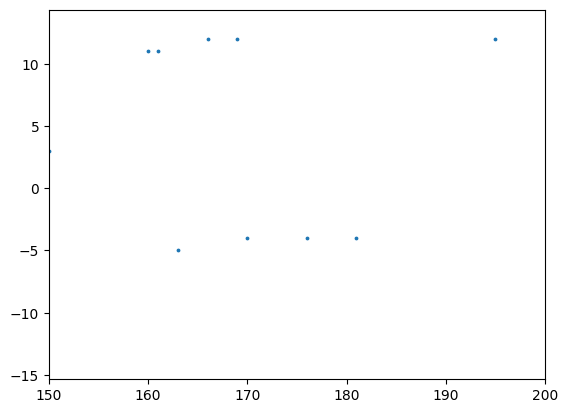

In [ ]:
plt.scatter(df_change['difference'],df_change['player_rating_change'],x)
plt.xlim(150,200)
plt.show()

In [ ]:
f1 = lambda x: np.quantile(x,0.01)
f2 = lambda x: np.quantile(x,0.99)

df_change.groupby(['player_result_value','player_rating_change']).agg(Lower = ('difference',f1),
                                                                      Upper = ('difference',f2))

Lower   Upper
player_result_value player_rating_change                
0.0                 -14.0                -392.64 -323.51
                    -13.0                -292.15 -226.35
                    -12.0                -212.80  -34.10
                    -11.0                -158.40 -115.20
                    -10.0                -109.12    1.62
                    -9.0                  -64.00   -8.00
                    -8.0                  -21.00   21.57
                    -7.0                   22.00   65.37
                    -6.0                   67.00  108.45
                    -5.0                  118.44  161.24
                    -4.0                  170.12  180.90
                    -3.0                  235.23  257.77
                    -2.0                  308.03  397.53
                     1.0                   99.00   99.00
0.5                 -6.0                 -396.00 -396.00
                    -5.0                 -240.00 -240.00
                    -4.0                 -137.00 -137.00
                    -3.0                 -148.97 -146.03
                    -2.0                 -109.22  -67.13
                    -1.0                  -61.38  -22.31
                     0.0                  -20.52   19.52
                     1.0                   19.69   64.00
                     2.0                   63.56  102.44
                     3.0                  125.12  149.62
                     4.0                  220.00  220.00
1.0                  1.0                 -398.00 -398.00
                     2.0                 -390.95 -296.42
                     3.0                 -292.70 -228.42
                     4.0                 -202.00 -175.14
                     5.0                 -158.52 -115.00
                     6.0                 -108.00  -69.00
                     7.0                  -66.00  -22.00
                     8.0                  -21.97   20.97
                     9.0                   22.00   65.59
                     10.0                  29.44  109.47
                     11.0                 115.30  160.90
                     12.0                 166.12  216.96
                     13.0                -105.44  145.44

In [ ]:
bucket_size = 10
df_change['bucket_num'] = df_change['difference']//bucket_size
df_change['bucket_label'] =  np.char.add(np.char.add(np.ndarray.astype(10*df_change['bucket_num'].values,dtype=str)," to "), np.ndarray.astype(10*(df_change['bucket_num'].values+ 1),dtype=str))

In [ ]:
df_change

,game_id,player_rating_prev,opponent_rating_prev,difference,expected_score,player_result_value,player_rating_change,player_rating,opponent_rating,sqrt_heuristic,sqrt_heuristic_error,custom_heuristic,custom_heuristic_error,bucket_num,bucket_label
1,27728963769,1618.0,1598.0,-20.0,0.528751,1.0,8.0,1626,1590,7.0,1.0,8.0,0.0,-2.0,-20.0 to -10.0
2,27729052317,1626.0,1628.0,2.0,0.497122,0.5,0.0,1626,1628,0.0,0.0,0.0,0.0,0.0,0.0 to 10.0
3,27729596667,1626.0,1751.0,125.0,0.327490,0.5,3.0,1629,1748,2.0,1.0,3.0,0.0,12.0,120.0 to 130.0
4,27729650709,1629.0,1552.0,-77.0,0.609033,1.0,6.0,1635,1546,6.0,0.0,6.0,0.0,-8.0,-80.0 to -70.0
5,27730195479,1635.0,1632.0,-3.0,0.504317,0.0,-8.0,1627,1640,-8.0,0.0,-8.0,0.0,-1.0,-10.0 to 0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,102885626207,1791.0,1707.0,-84.0,0.618584,1.0,6.0,1797,1701,6.0,0.0,6.0,0.0,-9.0,-90.0 to -80.0
1996,102885764715,1797.0,1710.0,-87.0,0.622650,0.5,-2.0,1795,1712,-2.0,0.0,-2.0,0.0,-9.0,-90.0 to -80.0
1997,102892255401,1795.0,1798.0,3.0,0.495683,1.0,8.0,1803,1790,8.0,0.0,8.0,0.0,0.0,0.0 to 10.0
1998,102892807055,1803.0,1760.0,-43.0,0.561568,0.0,-9.0,1794,1769,-9.0,0.0,-9.0,0.0,-5.0,-50.0 to -40.0


In [ ]:
df_exp = df_change.groupby('bucket_label').agg(count = ('game_id','count'),
                                             actual_score = ('player_result_value','mean'),
                                             expected_score = ('expected_score','mean')
                                             ).reset_index()

In [ ]:
a = np.array([1,2,3])

In [ ]:
np.ndarray.astype(a,dtype=str)

array(['1', '2', '3'], dtype='<U11')

In [ ]:
df_exp = df_exp[df_exp['count'] >= 10]

<Axes: xlabel='expected_score', ylabel='actual_score'>

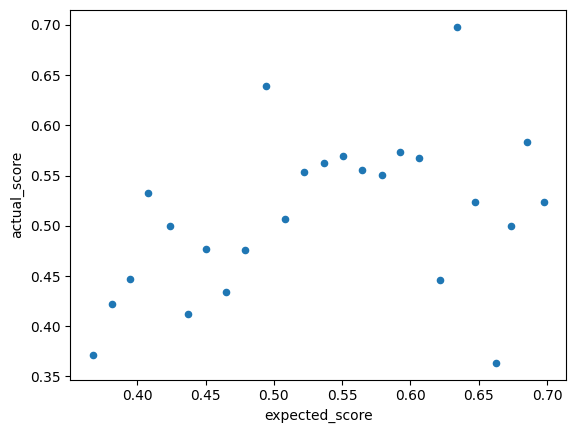

In [ ]:
plt.bar()